A multipurpose notebook for requesting all types of historical data. It can request new data or update existing DFs without the need to re-inputting parameters. It will request data based on inputted (or deciphered from the filename, for updates) parameters such as bar_size, duration, include IV data, use regular trading hours, etc.

In [1]:
import matplotlib.pyplot as plt
import pandas_market_calendars as pmc
import scipy.stats as stats
%matplotlib inline
import pandas as pd
import numpy as np
import math
import re
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 50, "display.max_columns", 10)
from ib_insync import *
util.startLoop()

In [2]:
PORT = 4002  # or 7497
ib = IB()
ib.connect('127.0.0.1', PORT, clientId=2)

<IB connected to 127.0.0.1:4002 clientId=2>

In [3]:
# MANDATORY input
is_update = False


In [21]:
INDICES = {'SPX', 'VIX'}
file_name = '1day_spx_max_iv_rth.pkl'  # starts after ..dfs/ and should include .pkl; only used for updates
recalculate_columns = True  # only for 1 day bars where customs columns are calculated.

# below is only used for original requests. It is ignored for updates, which instead decode the file name.
underlying_symbol = 'SPX'
underlying_type = 'IND'  # STK or IND
underlying_exchange = 'CBOE' or 'SMART'
get_iv_data  = True  # !! This often reduces rows because IV data typically doesn't go as far back as price data!
use_vix = True  # only for SPX, if grabbing IV data for SPX, use the VIX index itself.
duration = 'MAX'  # can be: # S, # D, # W, # M, # Y or 'MAX' for all available data
bar_size = '1 min'  # can be: # min(s), # hr, # day, etc.
use_rth = True  # False is useful for analyzing massive price swings outside RTH.

In [24]:
# load all the helper functions by running this cell

def get_earliest_timestamp(underlying, get_iv_data, use_rth, use_vix, vix=None) -> datetime:
    # grab earliest stamp using:
    # https://interactivebrokers.github.io/tws-api/head_timestamp.html#reqHeadTimeStamp
    trade_earliest = ib.reqHeadTimeStamp(underlying, 'TRADES', use_rth)
    if underlying.symbol.upper() == 'SPX' and get_iv_data and use_vix:
        # find the earliest available VIX timestamp
        iv_earliest = ib.reqHeadTimeStamp(vix, 'TRADES', use_rth)
    elif get_iv_data:
        # find the earliest available OPTION_IMPLIED_VOLATILITY timestamp
        iv_earliest = ib.reqHeadTimeStamp(underlying, 'OPTION_IMPLIED_VOLATILITY', use_rth)
    else:
        # No IV data requested, just return the earliest underlying timestamp
        return trade_earliest
    return max(trade_earliest, iv_earliest)


def calc_duration(earliest_timestamp) -> str:
    # calculate a duration in years for which data will be requested based on the earliest timestamp
    current = datetime.now().year
    earliest = earliest_timestamp.year
    return f'{(current - earliest) + 1} Y'


def add_back_space(string):
    return re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", string).strip()


def decipher_filename(filename) -> tuple:
    if not filename:
        print('Enter a valid filename.')
    filename = filename.split('.')[0]
    output = filename.split('_')
    output_length = len(output)
    bar_size = add_back_space(output[0])
    underlying_symbol = output[1].upper()
    duration = add_back_space(output[2])
    use_vix = False
    if output_length >= 4:
        if output[3] == 'iv':
            get_iv_data = True
            if underlying_symbol in INDICES:
                use_vix = True
        else:
            get_iv_data = False
    else:
        get_iv_data = False
    if output_length >= 5:
        if output[4] == 'rth':
            use_rth = True
        else:
            use_rth = False
    else:
        use_rth = False
    if underlying_symbol in INDICES:
        underlying_type = 'IND'
        underlying_exchange = 'CBOE'
    else:
        underlying_type = 'STK'
        underlying_exchange = 'SMART'

    return (bar_size, underlying_symbol, underlying_type,
            underlying_exchange, duration, get_iv_data, use_rth, use_vix)


def get_missing_days(existing_df):
    try:
        last_known_date = existing_df.iloc[-1]['date'].date()
    except AttributeError:
        last_known_date = existing_df.iloc[-1]['date']
    today = datetime.now().date()
    days_missing = (today - last_known_date).days  # total days, not trading days
    today = str(today).replace('-', '')
    end_date_time = f"{today} 24:00:00 EST"
    days_missing = f"{days_missing} D"
    print(f'last date in df: {last_known_date}, today: {today} ({days_missing} days)')
    return days_missing, end_date_time


def show(bar_size, underlying_symbol, underlying_type, underlying_exchange,
         duration, get_iv_data, use_rth, use_vix, end_date_time=False, use_date_df=False):
    print('----------------------------------')
    print(f'bar_size:             {bar_size}')
    print(f'underlying_symbol:    {underlying_symbol}')
    print(f'underlying_type:      {underlying_type}')
    print(f'underlying_exchange:  {underlying_exchange}')
    print(f'duration:             {duration}')
    print(f'get_iv_data:          {get_iv_data}')
    print(f'use_rth:              {use_rth}')
    print(f'use_vix:              {use_vix}')
    print(f'end_date_time:        {end_date_time}')
    print(f'use_date_df:          {use_date_df}')
    print('----------------------------------')


def recalculate_column_values(df, bar_size):
    df['prev_close'] = df['close'].shift(1)
    df['iv_prev_close'] = df['iv_close'].shift(1)

    # open-close movement
    df['open_close'] = (df['close'] - df['open']) / df['open']  # former 'movement'; intraday movement
    df['close_close'] = (df['prev_close'] - df['close']) / df['prev_close']  # interday movement
    df['close_open'] = (df['open'] - df['prev_close']) / df['prev_close']  # overnight movement

    df['iv_open_close'] = (df['iv_close'] - df['iv_open']) / df['iv_open']  # former 'movement'; intraday movement
    df['iv_close_close'] = (df['iv_prev_close'] - df['iv_close']) / df['iv_prev_close']  # interday movement
    df['iv_close_open'] = (df['iv_open'] - df['iv_prev_close']) / df['iv_prev_close']  # overnight movement

    # realized vol taken from this formula: https://www.realvol.com/VolFormula.htm
    if bar_size == '1 min':
        df['real_vol'] = np.sqrt(252/(1/390) * np.log(df['open'] / df['close']) ** 2)
        df['previous_vol'] = df['real_vol'].shift(1)
        df['max_vol'] = np.sqrt(252/(1/390) * np.log(df['high'] / df['low']) ** 2)
    elif bar_size == '1 hour':
        df['real_vol'] = np.sqrt(252/(1/6.5) * np.log(df['open'] / df['close']) ** 2)
        df['previous_vol'] = df['real_vol'].shift(1)
        df['max_vol'] = np.sqrt(252/(1/6.5) * np.log(df['high'] / df['low']) ** 2)
    elif bar_size == '1 day':
        df['real_vol'] = np.sqrt(252 * np.log(df['open'] / df['close']) ** 2)
        df['previous_vol'] = df['real_vol'].shift(1)
        df['max_vol'] = np.sqrt(252 * np.log(df['high'] / df['low']) ** 2)
    else:
        print(f'unknown bar_size. manually recalculate real_vol, previous_vol, max_vol based on bar_size of {bar_size}')

    df['max_up'] = (df['high'] - df['open']) / df['open']
    df['max_down'] = (df['low'] - df['open']) / df['open']

    df['peak_move'] = (((df['max_up'] > df['max_down'].abs()) * df['max_up']) + 
                       ((df['max_up'] <= df['max_down'].abs()) * df['max_down']))

    df['day'] = df['date'].astype('datetime64[ns]').dt.dayofweek
    return df


In [128]:
# create the underlying contract objects based on the above inputs
if underlying_type == 'STK':
    underlying = Stock(underlying_symbol, underlying_exchange, 'USD')
elif underlying_type == 'IND':
    underlying = Index(underlying_symbol, underlying_exchange)
    if underlying_symbol == 'SPX' and get_iv_data and use_vix:
        vix = Index('VIX', 'CBOE')
else:
    raise ValueError("INVALID INPUT(S)!")

In [23]:
if not is_update:
    # get today's date for `endDateTime`
    today = str(datetime.now().date()).replace('-', '')
    end_date_time = f"{today} 24:00:00 EST"

    stripped_duration = duration.replace(' ', '')  # max is unchanged, which is as intended.
    stripped_barsize = bar_size.replace(' ', '')
    iv = '_iv' if get_iv_data else ''
    rth = '_rth' if use_rth else '_nonrth'

    if duration == 'MAX':
        if bar_size == '1 min':
            print("WARNING: MAX DURATION WITH 1 MIN DATA DETECTED. THIS MAY TAKE A LONG TIME!")
        if use_vix:
            earliest_timestamp = get_earliest_timestamp(underlying, get_iv_data, use_rth, use_vix, vix)
        else:
            earliest_timestamp = get_earliest_timestamp(underlying, get_iv_data, use_rth, use_vix)
        duration = calc_duration(earliest_timestamp)

    file_name = f'{stripped_barsize}_{underlying_symbol}_{stripped_duration}{iv}{rth}.pkl'.lower()

spx earliest 2004-03-04 14:30:00
vix earliest 2005-10-03 13:30:00
max earlierst 2005-10-03 13:30:00


In [25]:
# Flag to either update a df to True to ignore all flags below and instead decipher from the filename
# set the parameters here and then just run all the below cells sequentially.

if is_update:
    existing_df = pd.read_pickle(f'../../dfs/{file_name}')
    existing_df.info()
    parameters = decipher_filename(file_name)
    bar_size = parameters[0]
    underlying_symbol = parameters[1]
    underlying_type = parameters[2]
    underlying_exchange = parameters[3]
    duration = parameters[4]
    get_iv_data = parameters[5]
    use_rth = parameters[6]
    use_vix = parameters[7]
    duration, end_date_time = get_missing_days(existing_df)


if 'min' in bar_size or 'hr' in bar_size:
    use_date_df = True
else:
    use_date_df = False

show(bar_size, underlying_symbol, underlying_type, underlying_exchange,
     duration, get_iv_data, use_rth, use_vix, end_date_time, use_date_df)

----------------------------------
bar_size:             1 min
underlying_symbol:    SPX
underlying_type:      IND
underlying_exchange:  CBOE
duration:             18 Y
get_iv_data:          True
use_rth:              True
use_vix:              True
end_date_time:        20220308 24:00:00 EST
use_date_df:          True
----------------------------------


In [26]:
# pull 1 D bars to get the valid trading days.
if use_date_df:
    bars = ib.reqHistoricalData(underlying, endDateTime=end_date_time, durationStr=duration,
                                barSizeSetting='1 day',whatToShow='TRADES', useRTH=use_rth)
    date_df = pd.DataFrame(bars)
    print(date_df)

            date   open   high    low  close  volume  average  barCount
0     2005-10-03  12.37  12.62  11.98  12.43     0.0      0.0      1556
1     2005-10-04  12.50  13.14  12.11  13.11     0.0      0.0      1556
2     2005-10-05  13.15  14.55  12.97  14.54     0.0      0.0      1556
3     2005-10-06  14.53  15.63  14.04  15.07     0.0      0.0      1556
4     2005-10-07  14.56  14.82  14.30  14.54     0.0      0.0      1556
...          ...    ...    ...    ...    ...     ...      ...       ...
4115  2022-03-02  34.20  34.41  30.12  30.74     0.0      0.0      2565
4116  2022-03-03  30.52  32.01  29.31  30.48     0.0      0.0      2442
4117  2022-03-04  31.90  34.65  31.47  31.98     0.0      0.0      2633
4118  2022-03-07  35.88  36.55  32.59  36.45     0.0      0.0      2651
4119  2022-03-08  36.19  37.52  32.78  34.12     0.0      0.0      2053

[4120 rows x 8 columns]


In [61]:
"""
request the underlying price and IV historical data
"""
# DO NOT PROCESS THE BARS HERE!!! LEAVE THEM AS PYTHON LISTS, THEN CLEAN/MODIFY IN SUBSEQUENT CELLS!
date_df_size = len(date_df)

if use_date_df:
    price_bars = []
    for i, date in enumerate(date_df['date']):
        i += 1
        date = str(date).replace('-', '')
        date = f"{date} 24:00:00 EST"
        bars = ib.reqHistoricalData(underlying, endDateTime=date, durationStr='1 D',
                                    barSizeSetting=bar_size ,whatToShow='TRADES', useRTH=use_rth)
        ib.sleep(3.5)  # avoid exceeding rate limit
        print(f'{100 * (i) / date_df_size:.2f}% complete with price data ({i} of {date_df_size}), [{date}]', end='\r')
        price_bars.append(bars)
    if get_iv_data:
        # print('-------------------')
        # automatically run this here to grab both in one cell
        if underlying_symbol == 'SPX' and get_iv_data and use_vix:
            print('getting VIX TRADES data')
            underlying = vix
            what_to_show = 'TRADES'
            scale_down = True
        else:
            print('getting OPTION_IMPLIED_VOLATILITY data')
            # underlying is unchanged from above, just grab IV using what_to_show below
            what_to_show = 'OPTION_IMPLIED_VOLATILITY'
            scale_down = False
        iv_bars = []
        for i, date in enumerate(date_df['date']):
            i += 1
            date = str(date).replace('-', '')
            date = f"{date} 24:00:00 EST"
            bars = ib.reqHistoricalData(underlying, endDateTime=date, durationStr='1 D',
                                        barSizeSetting=bar_size ,whatToShow=what_to_show,
                                        useRTH=use_rth)
            ib.sleep(3.5)  # avoid exceeding rate limit
            print(f'{100 * (i) / date_df_size:.2f}% complete with IV data ({i} of {date_df_size}), [{date}]', end='\r')
            iv_bars.append(bars)
else:
    price_bars = ib.reqHistoricalData(underlying, endDateTime=end_date_time, durationStr=duration,
                                      barSizeSetting=bar_size ,whatToShow='TRADES', useRTH=use_rth)
    if get_iv_data:
        # print('-------------------')
        if underlying_symbol == 'SPX' and get_iv_data and use_vix:
            underlying = vix
            what_to_show = 'TRADES'
            scale_down = True
        else:
            what_to_show = 'OPTION_IMPLIED_VOLATILITY'
            scale_down = False
        iv_bars = ib.reqHistoricalData(underlying, endDateTime=end_date_time, durationStr=duration,
                                       barSizeSetting=bar_size ,whatToShow=what_to_show, useRTH=use_rth)


getting VIX TRADES data


In [96]:
# clean the nested bardata that results from using a date df and appending data.
if use_date_df:
    a = []
    for day in price_bars:
        if 'min' in bar_size:
            for minute in day:
                if minute != []:
                    a.append(minute)
        else:
            a.append(day)
    price_df = pd.DataFrame(a)
    if get_iv_data:
        b = []
        for day in iv_bars:
            if 'min' in bar_size:
                for minute in day:
                    if minute != []:
                        b.append(minute)
            else:
                b.append(day)
        iv_df = pd.DataFrame(b)
else:
    price_df = pd.DataFrame(price_bars)
    if get_iv_data:
        iv_df = pd.DataFrame(iv_bars)


In [108]:
price_df = pd.read_pickle('./1min_price_df.pkl')
print(price_df)

                       date     open     high      low    close
0       2004-03-12 09:30:00  1110.58  1111.22  1110.58  1111.01
1       2004-03-12 09:31:00  1111.10  1111.63  1111.10  1111.63
2       2004-03-12 09:32:00  1111.72  1112.18  1111.72  1112.18
3       2004-03-12 09:33:00  1112.09  1112.18  1112.09  1112.09
4       2004-03-12 09:34:00  1111.46  1111.55  1111.15  1111.15
...                     ...      ...      ...      ...      ...
1772384 2022-03-07 15:55:00  4201.06  4205.02  4201.06  4204.11
1772385 2022-03-07 15:56:00  4204.43  4206.89  4203.42  4203.82
1772386 2022-03-07 15:57:00  4203.94  4210.72  4203.78  4208.31
1772387 2022-03-07 15:58:00  4208.62  4210.68  4205.93  4205.93
1772388 2022-03-07 15:59:00  4205.77  4206.60  4199.85  4201.57

[1772389 rows x 5 columns]


In [109]:
print(iv_df)

                       date  iv_open  iv_high  iv_low  iv_close
0       2005-10-03 09:31:00   0.1237   0.1237  0.1237    0.1237
1       2005-10-03 09:32:00   0.1237   0.1237  0.1235    0.1235
2       2005-10-03 09:33:00   0.1237   0.1238  0.1235    0.1238
3       2005-10-03 09:34:00   0.1234   0.1238  0.1234    0.1238
4       2005-10-03 09:35:00   0.1239   0.1239  0.1236    0.1238
...                     ...      ...      ...     ...       ...
2168956 2022-03-08 16:10:00   0.3532   0.3532  0.3518    0.3518
2168957 2022-03-08 16:11:00   0.3510   0.3511  0.3507    0.3511
2168958 2022-03-08 16:12:00   0.3513   0.3519  0.3513    0.3519
2168959 2022-03-08 16:13:00   0.3517   0.3517  0.3509    0.3512
2168960 2022-03-08 16:14:00   0.3510   0.3510  0.3502    0.3504

[2168961 rows x 5 columns]


In [106]:
# Further clean up the data
price_df.drop(['volume', 'average', 'barCount'], axis=1, inplace=True)
if get_iv_data:
    iv_df.drop(['volume', 'average', 'barCount'], axis=1, inplace=True)
    if scale_down:
        # VIX data are on a /100 basis. OPTION_IMPLIED_VOLATILITY is decimal. Scale VIX down to match:
        iv_df['open'] /= 100
        iv_df['high'] /= 100
        iv_df['low'] /= 100
        iv_df['close'] /= 100
    # rename columns to avoid a collision when merging price_df later on.
    iv_df.rename(columns={"open": "iv_open", "high": "iv_high", "low": "iv_low", "close": "iv_close"}, inplace=True)


In [110]:
# merge the two DFs and drop duplicate rows
if get_iv_data:
    # there is both price and iv data. merge the two.
    new_df = pd.merge(price_df, iv_df, on='date')
else:
    new_df = price_df
if is_update:
    df = existing_df.append(new_df)
    df.reset_index(inplace=True, drop=True)
    df.drop_duplicates(subset=['date'], inplace=True)
else:
    df = new_df
if recalculate_columns:
    df = recalculate_column_values(df, bar_size)
print(df)

                       date     open     high      low    close  ...  \
0       2005-10-03 09:33:00  1230.03  1230.12  1230.03  1230.12  ...   
1       2005-10-03 09:34:00  1230.03  1230.03  1229.65  1229.65  ...   
2       2005-10-03 09:35:00  1229.56  1229.85  1229.46  1229.85  ...   
3       2005-10-03 09:36:00  1229.75  1229.75  1229.57  1229.66  ...   
4       2005-10-03 09:37:00  1229.76  1230.04  1229.74  1229.93  ...   
...                     ...      ...      ...      ...      ...  ...   
1599920 2022-03-07 15:55:00  4201.06  4205.02  4201.06  4204.11  ...   
1599921 2022-03-07 15:56:00  4204.43  4206.89  4203.42  4203.82  ...   
1599922 2022-03-07 15:57:00  4203.94  4210.72  4203.78  4208.31  ...   
1599923 2022-03-07 15:58:00  4208.62  4210.68  4205.93  4205.93  ...   
1599924 2022-03-07 15:59:00  4205.77  4206.60  4199.85  4201.57  ...   

          max_vol    max_up  max_down  peak_move  day  
0        0.022937  0.000073  0.000000   0.000073    0  
1        0.096865  0.00

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599925 entries, 0 to 1599924
Data columns (total 24 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1599925 non-null  datetime64[ns]
 1   open            1599925 non-null  float64       
 2   high            1599925 non-null  float64       
 3   low             1599925 non-null  float64       
 4   close           1599925 non-null  float64       
 5   iv_open         1599925 non-null  float64       
 6   iv_high         1599925 non-null  float64       
 7   iv_low          1599925 non-null  float64       
 8   iv_close        1599925 non-null  float64       
 9   prev_close      1599924 non-null  float64       
 10  iv_prev_close   1599924 non-null  float64       
 11  open_close      1599925 non-null  float64       
 12  close_close     1599924 non-null  float64       
 13  close_open      1599924 non-null  float64       
 14  iv_open_close   15

<AxesSubplot:xlabel='date'>

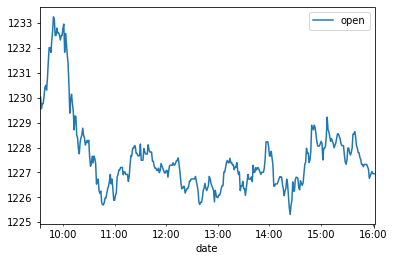

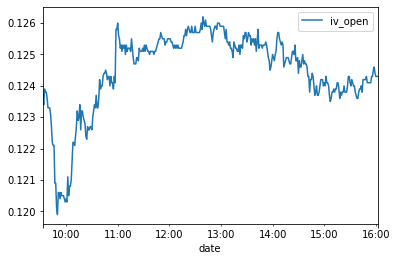

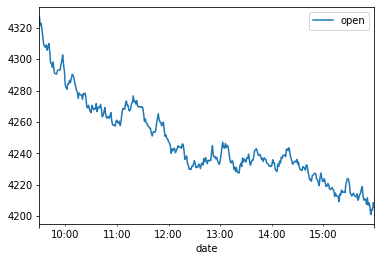

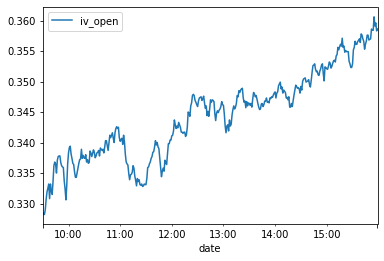

In [115]:
# plot the underlying and iv to visually identify any issues
df.plot('date', 'open')
df.plot('date', 'iv_open')

# below are for 1 min bar size
# df.iloc[:390].plot('date', 'open')
# df.iloc[:390].plot('date', 'iv_open')
# df.iloc[-390:].plot('date', 'open')
# df.iloc[-390:].plot('date', 'iv_open')

In [116]:
# programmatically test for errors, checking for gaps > 5 days.
delta = pd.Timedelta(days=5)
pf = df.copy()
pf['gap'] = (pf['date'] > pf['date'].shift(1) + delta)
idx = pf[pf['gap'] == True].index
print(pf.iloc[idx][['date']])

                     date
56001 2006-05-22 09:31:00


In [125]:
# if a gap is found in the above cell, split the df around that gap and save the pre_gap as a pickle.
# pre_gap_df = df.iloc[:idx[0]]
# df = df.iloc[idx[0]:]
# pre_gap_df.to_pickle(f'../../dfs/pre_gap_{file_name}.pkl')

In [127]:
if is_update:
    # ensure no jumps exist where the new df was appended.
    days_missing = int(duration.split(' ')[0])  # turn  string of 'x D' to just grab the int, x.
    df.iloc[-(days_missing+10):].plot('date', 'open')

In [84]:
df.to_pickle(f'../../dfs/{file_name}')
ib.disconnect()  # disconnect from IB
print(f'last saved on {datetime.now().date()}, filename: {file_name}')

last saved on 2022-03-08, filename: 1min_spx_max_iv_rth.pkl
